In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from DataLoader import load_data

In [4]:
data_file = np.load("./public_data.npz", allow_pickle=True)
data = data_file["data"]
y = data_file["labels"]
y[y == "healthy"] = 0
y[y == "unhealthy"] = 1
y = y.astype(np.float32)

Removing trolls, shreks and duplicates


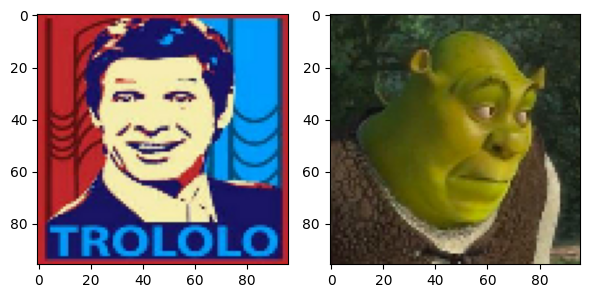

In [5]:
print("Removing trolls, shreks and duplicates")
initialDataN = data.shape[0]


troll = data[338]
shrek = data[58]


fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(troll / 255)
axes[1].imshow(shrek / 255)
plt.tight_layout()
plt.show()

In [6]:
mask = []
for i in range(data.shape[0]):
    if np.array_equal(data[i], troll) or np.array_equal(data[i], shrek):
        mask.append(False)
    else:
        mask.append(True)
data = data[mask]
y = y[mask]

In [7]:
data, indexes = np.unique(data, axis=0, return_index=True)
y = y[indexes]

print("Removed Images: " + str(initialDataN - data.shape[0]))

Removed Images: 350


In [8]:
y = tfk.utils.to_categorical(y, num_classes=2)

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data, y, random_state=seed, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=seed, test_size=0.2, stratify=y_train_val)

In [10]:
model = tfk.applications.Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

In [11]:
model.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))
x = model(inputs, training=False)

output = tfkl.Dense(2, activation="softmax")(x)
tl_model = tfk.Model(inputs, output)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20865578 (79.60 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [12]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing
    y = y_train,
    batch_size = 16,
    epochs = 20,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/20
194/194 [==============================] - 13s 53ms/step - loss: 0.5606 - accuracy: 0.7133 - val_loss: 0.4831 - val_accuracy: 0.7758
Epoch 2/20
194/194 [==============================] - 9s 44ms/step - loss: 0.4881 - accuracy: 0.7680 - val_loss: 0.4735 - val_accuracy: 0.7732
Epoch 3/20
194/194 [==============================] - 9s 46ms/step - loss: 0.4619 - accuracy: 0.7806 - val_loss: 0.4631 - val_accuracy: 0.7848
Epoch 4/20
194/194 [==============================] - 9s 44ms/step - loss: 0.4397 - accuracy: 0.7916 - val_loss: 0.4899 - val_accuracy: 0.7732
Epoch 5/20
194/194 [==============================] - 9s 44ms/step - loss: 0.4233 - accuracy: 0.8044 - val_loss: 0.4605 - val_accuracy: 0.7809
Epoch 6/20
194/194 [==============================] - 9s 44ms/step - loss: 0.4203 - accuracy: 0.8112 - val_loss: 0.5040 - val_accuracy: 0.7680
Epoch 7/20
194/194 [==============================] - 9s 44ms/step - loss: 0.3953 - accuracy: 0.8231 - val_loss: 0.4644 - val_accuracy: 0.786

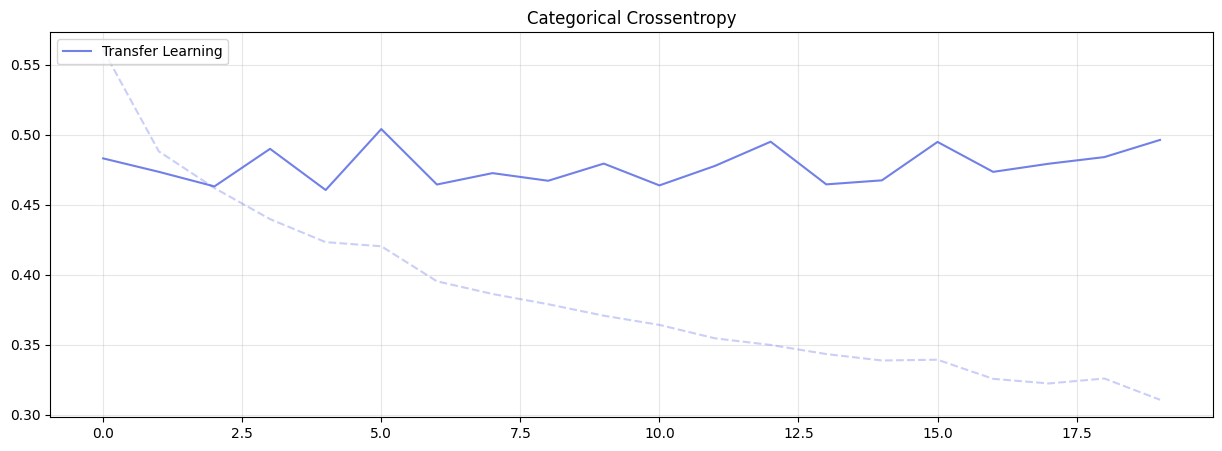

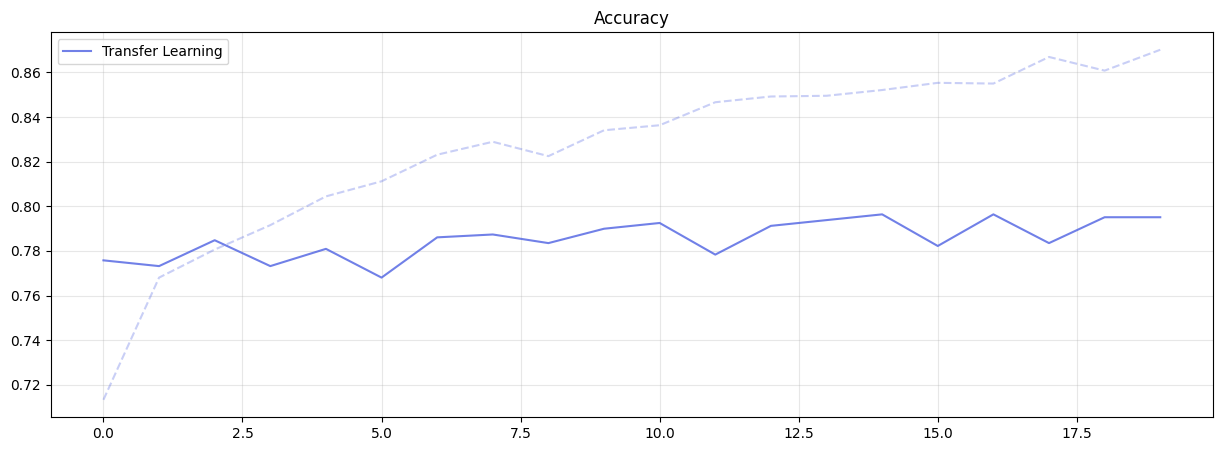

In [13]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [14]:
# Save the best model
tl_model.save('XceptionTransferLearning')
del tl_model

: 